In [1]:
from os.path import join

from pandas import read_csv

from sklearn.svm import SVC
from sklearn.ensemble import RandomForestClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.naive_bayes import GaussianNB 

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import normalize

from sklearn.metrics import f1_score

In [2]:
data_dir = "/home/benoit/data/dreem_challenge/"
labels_path = "/home/benoit/data/dreem_challenge/y_train.csv"

labels = read_csv(labels_path)

In [3]:
import h5py

d = h5py.File(join(data_dir, 'X_train', 'X_train.h5'), 'r')

subject = d['index'][()]

In [4]:
from tools.processing import load_features, merge_features

features_1 = load_features(join(data_dir, "computed", 'base_1_train.csv'))
features_2 = load_features(join(data_dir, "computed", 'base_2_train.csv'))
features_3 = load_features(join(data_dir, "computed", 'base_3_train.csv'))
features_4 = load_features(join(data_dir, "computed", 'base_4_train.csv'))

f_train = merge_features([features_1, features_2, features_3, features_4])
y = labels['sleep_stage']
f_train = f_train.drop(['abs_index'], axis=1)

In [5]:
f_train.shape

(24688, 92)

In [6]:
from sklearn.preprocessing import StandardScaler
from neurocombat_sklearn import CombatModel



X_train, X_test, y_train, y_test, subject_train, subject_test = train_test_split(f_train, y, subject, test_size = 0.3)

# Features preprocessing (noramlization etc...)

scaler = StandardScaler().fit(X_train)

X_train = scaler.transform(X_train)
X_test = scaler.transform(X_test)

combat = CombatModel()

X_train = combat.fit_transform(X_train, subject_train.reshape(-1, 1))
X_test = combat.fit(X_test, subject_test.reshape(-1, 1))

/home/benoit/.local/lib/python3.8/site-packages/neurocombat_sklearn/neurocombat_sklearn.py:258: RuntimeWarning: invalid value encountered in true_divide
  standardized_data = ((data - standardized_mean) / np.dot(np.sqrt(self.var_pooled), np.ones((1, n_samples))))
/home/benoit/.local/lib/python3.8/site-packages/neurocombat_sklearn/neurocombat_sklearn.py:258: RuntimeWarning: invalid value encountered in true_divide
  standardized_data = ((data - standardized_mean) / np.dot(np.sqrt(self.var_pooled), np.ones((1, n_samples))))


AttributeError: discrete_covariates_used

In [15]:
# Feature Selection
from sklearn.feature_selection import SelectKBest
from sklearn.feature_selection import f_classif

# slct = SelectKBest(f_classif, k=10)

# X_train = slct.fit_transform(X_train, y_train)
# X_test = slct.transform(X_test)


In [16]:
# Model initialization

clf = RandomForestClassifier(n_estimators=100, 
                             criterion='gini', 
                             max_depth=None, 
                             min_samples_leaf=0.001, 
                             class_weight="balanced",
                             bootstrap = True)

#clf = KNeighborsClassifier(n_neighbors = 15)
# clf= SVC(kernel = 'linear', C = 0.1, verbose=1)
#clf = GaussianNB()

In [17]:
# Hyperparameter tuning (k-fold etc...)
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import make_scorer

#scorer_f1 = make_scorer(f1_score, average="weighted")

param_grid = [
  {'C': [0.1, 1, 10, 100], 'gamma': [0.01, 0.001, 0.0001], 'kernel': ['rbf']},
 ]

#tuner = GridSearchCV(clf, param_grid, scorer_f1)

#res = tuner.fit(X_train, y_train)
# print(res)

In [18]:
# Model training

clf.fit(X_train, y_train)

ValueError: Input contains NaN, infinity or a value too large for dtype('float32').

In [46]:
# Model verifications

predictions_train = clf.predict(X_train)
print(f"Training score - {f1_score(predictions_train, y_train, average='weighted')}")

predictions_test = clf.predict(X_test)
print(f"Testing score - {f1_score(predictions_test, y_test, average='weighted')}")

Training score - 0.8154240828147661
Testing score - 0.7235391885492849


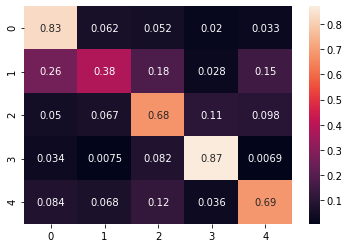

In [47]:
# Analyse des résultats 
from sklearn.metrics import confusion_matrix
from seaborn import heatmap
from matplotlib.pyplot import show

cm = confusion_matrix(y_test, predictions_test, normalize="true")
ax = heatmap(cm, annot=True)
show()

In [48]:
from collections import Counter

print(Counter(y_test))
print(Counter(predictions_test))

Counter({2: 2828, 3: 1593, 4: 1403, 0: 1076, 1: 507})
Counter({2: 2371, 3: 1773, 4: 1367, 0: 1339, 1: 557})


In [29]:
# Loading evaluation data

f_1_e = load_features(join(data_dir, "computed", 'base_1_eval.csv'))
f_2_e = load_features(join(data_dir, "computed", 'base_2_eval.csv'))
f_3_e = load_features(join(data_dir, "computed", 'base_3_eval.csv'))
f_4_e = load_features(join(data_dir, "computed", 'base_4_eval.csv'))

f_eval = merge_features([f_1_e, f_2_e, f_3_e, f_4_e])

f_eval = f_eval.drop(['abs_index'], axis=1)

# assert f_train.keys() == f_eval.keys()

# Features preprocessing & Feature selection (both must be applied as for training features)

X_eval = scaler.transform(f_eval)

In [30]:
# Making prediction on eval data

eval_pred = clf.predict(X_eval)

sub = read_csv(join(data_dir, 'sample_submission.csv'))
sub['sleep_stage'] = eval_pred

sub.to_csv("output/submission.csv", index=False)